In [2]:
import numpy as np
import math
from kapteyn import kmpfit

from astropy.table import Table, join
from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import rc
%matplotlib inline

from desitarget.targetmask import desi_mask
from desitarget.sv1 import sv1_targetmask
from desitarget.sv2 import sv2_targetmask
from desitarget.sv3 import sv3_targetmask
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask
import specprodDB.load as db
from desiutil.log import get_logger, DEBUG

import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import json
import pickle

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (24,8)

In [3]:
with fits.open("/global/cfs/cdirs/desi/public/edr/vac/edr/fastspecfit/fuji/v3.2/catalogs/fastspec-fuji.fits", memmap = True) as hdul:
    catalog1 = hdul[1].data
    catalog2 = hdul[2].data
    is_elg = (catalog2["SV1_DESI_TARGET"] & sv1_desi_mask['ELG'] != 0)|(catalog2["SV2_DESI_TARGET"] & sv2_desi_mask['ELG'] != 0)|(catalog2["SV3_DESI_TARGET"] & sv3_desi_mask['ELG'] != 0)
    ELG = catalog1[is_elg]

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def selection_Lya(data = ELG, save = None, redshift_range = [1.96, 7.08], ELG = ELG, Lya_SNR = 5, CIV_SNR = 2):
    
    def BOX_SNR(dataset, feature):
        signal = dataset[str(feature) + "_BOXFLUX"]
        noise = dataset[str(feature) + "_BOXFLUX_IVAR"]
        preSNR = signal / noise ** (-1 / 2)
        return np.nan_to_num(preSNR)

    mask_redshift_low = data["Z"] < redshift_range[1]
    mask_redshift_high = data["Z"] > redshift_range[0]
    selection = ELG[mask_redshift_low & mask_redshift_high] 
    ELG_noQSO = selection[BOX_SNR(selection, "CIV_1549") < CIV_SNR]
    ELG_noQSO = ELG_noQSO[BOX_SNR(ELG_noQSO, "LYALPHA") > Lya_SNR]
    selection = ELG_noQSO[ELG_noQSO["LYALPHA_NPIX"] < 50]
    
    spectra = []
    print("First stage finsishes!")
    print("Start second stage")
    
    n = 0
    
    for i in selection:
        n += 1
        print(f"\rProcess: {str(n / len(selection) * 100)} %", end = "")
        dic = {}
        path = f"/global/cfs/cdirs/desi/spectro/redux/iron/healpix/{i['SURVEY']}/i['PROGRAM']/{i['HEALPIX'] // 100}/{i['HEALPIX']}/coadd-main-dark-{i['HEALPIX']}.fits"
        try:
            with fits.open(path, memmap = True) as hdul:
                targetid_file = hdul[1].data["TARGETID"]
                index = np.argwhere(targetid_file == i[0])
                if index.shape[0] * index.shape[1] == 1:
                    wave = np.concatenate((hdul[3].data, hdul[8].data, hdul[13].data))
                    flux = np.concatenate((hdul[4].data[index[0][0]], hdul[9].data[index[0][0]], hdul[14].data[index[0][0]]))
                    ivar = np.concatenate((hdul[5].data[index[0][0]], hdul[10].data[index[0][0]], hdul[15].data[index[0][0]]))
                    dic["specid"] = i["TARGETID"]
                    dic["healpix"] = i["HEALPIX"]
                    dic["redshift"] = i["Z"]
                    dic["wavelength"] = wave
                    dic["flux"] = flux
                    dic["ivar"] = ivar
                    dic["_dr"] = "DESI-IRON"
                    spectra.append(dic)
                else:
                    print(f"\nMultiple targetid:{i['TARGETID']}")
        except:
            print(f"\nOther problems:{i['TARGETID']}")

    print("\nSecond stage finsishes!")
    
    if save != None:
        with open(str(save) + "OII_catalog.pkl", "wb") as fh:
            pickle.dump(spectra, fh)
    else:
        pass
        
    return spectra

In [6]:
spectra = selection_Lya()

First stage finsishes!
Start second stage
Process: 0.31746031746031744 %
Other problems:39627306657913116
Process: 0.6349206349206349 %
Other problems:39627658614541257
Process: 0.9523809523809524 %
Other problems:39627658631321939
Process: 1.2698412698412698 %
Other problems:39627664633371817
Process: 1.5873015873015872 %
Other problems:39627694748469747
Process: 1.9047619047619049 %
Other problems:39627724976817250
Process: 2.2222222222222223 %
Other problems:39627737060609628
Process: 2.5396825396825395 %
Other problems:39627740097286082
Process: 2.857142857142857 %
Other problems:39627746128694375
Process: 3.1746031746031744 %
Other problems:39627746137083806
Process: 3.492063492063492 %
Other problems:39627749123427440
Process: 3.8095238095238098 %
Other problems:39627752084603814
Process: 4.1269841269841265 %
Other problems:39627752109774044
Process: 4.444444444444445 %
Other problems:39627752160103349
Process: 4.761904761904762 %
Other problems:39627757533003845
Process: 5.07936

In [7]:
with open("../DESI_LAE_dataset/correct_catalog.pkl", "wb") as fh:
    pickle.dump(spectra, fh)

In [16]:
def plot_spec(spectra, end, init = 0, path = None, Lya = True):
    for i in range(init, end):
        record = spectra[i]
    
        flux = record["flux"]
        wavelength = record["wavelength"]
        redshift = record["redshift"]
        ivar = record["ivar"]
        targetid = record["specid"]

        w = wavelength
        f = flux
        iv = np.sqrt(ivar) ** -1
        
        if np.max(f) == np.inf:
            f[np.where(f == np.inf)] = np.median(f)
        elif np.max(iv) == np.inf:
            iv[np.where(iv == np.inf)] = np.median(iv)
        
        if Lya == True:
            min = 1215.67 * (redshift + 1) - 25
            max = 1215.67 * (redshift + 1) + 25
            mask_min = wavelength > min
            mask_max = wavelength < max
            w = wavelength[mask_min & mask_max]
            f = flux[mask_min & mask_max]
            iv = np.sqrt(ivar[mask_min & mask_max]) ** -1
            if np.max(f) == np.inf:
                f[np.where(f == np.inf)] = np.median(f)
            elif np.max(iv) == np.inf:
                iv[np.where(iv == np.inf)] = np.median(iv)
        else:
            pass

        plt.close()
        plt.title(f"target ID = {targetid}\n"
                  f"Redshift = {redshift}\n", loc='left')
        plt.xlabel('$\lambda\ [\AA]$')
        plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
        
        plt.plot(w, f, color = 'k', alpha = 0.2, label='Unsmoothed spectrum')
        
        plt.plot(w, convolve(f, Gaussian1DKernel(2)), color='k', label='Smoothed spectrum')
    
        plt.legend()
        plt.savefig(str(path) + f"/spectrum_{targetid}_Lya.png", bbox_inches='tight')

/tmp/ipykernel_1816417/3994647407.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  iv = np.sqrt(ivar) ** -1


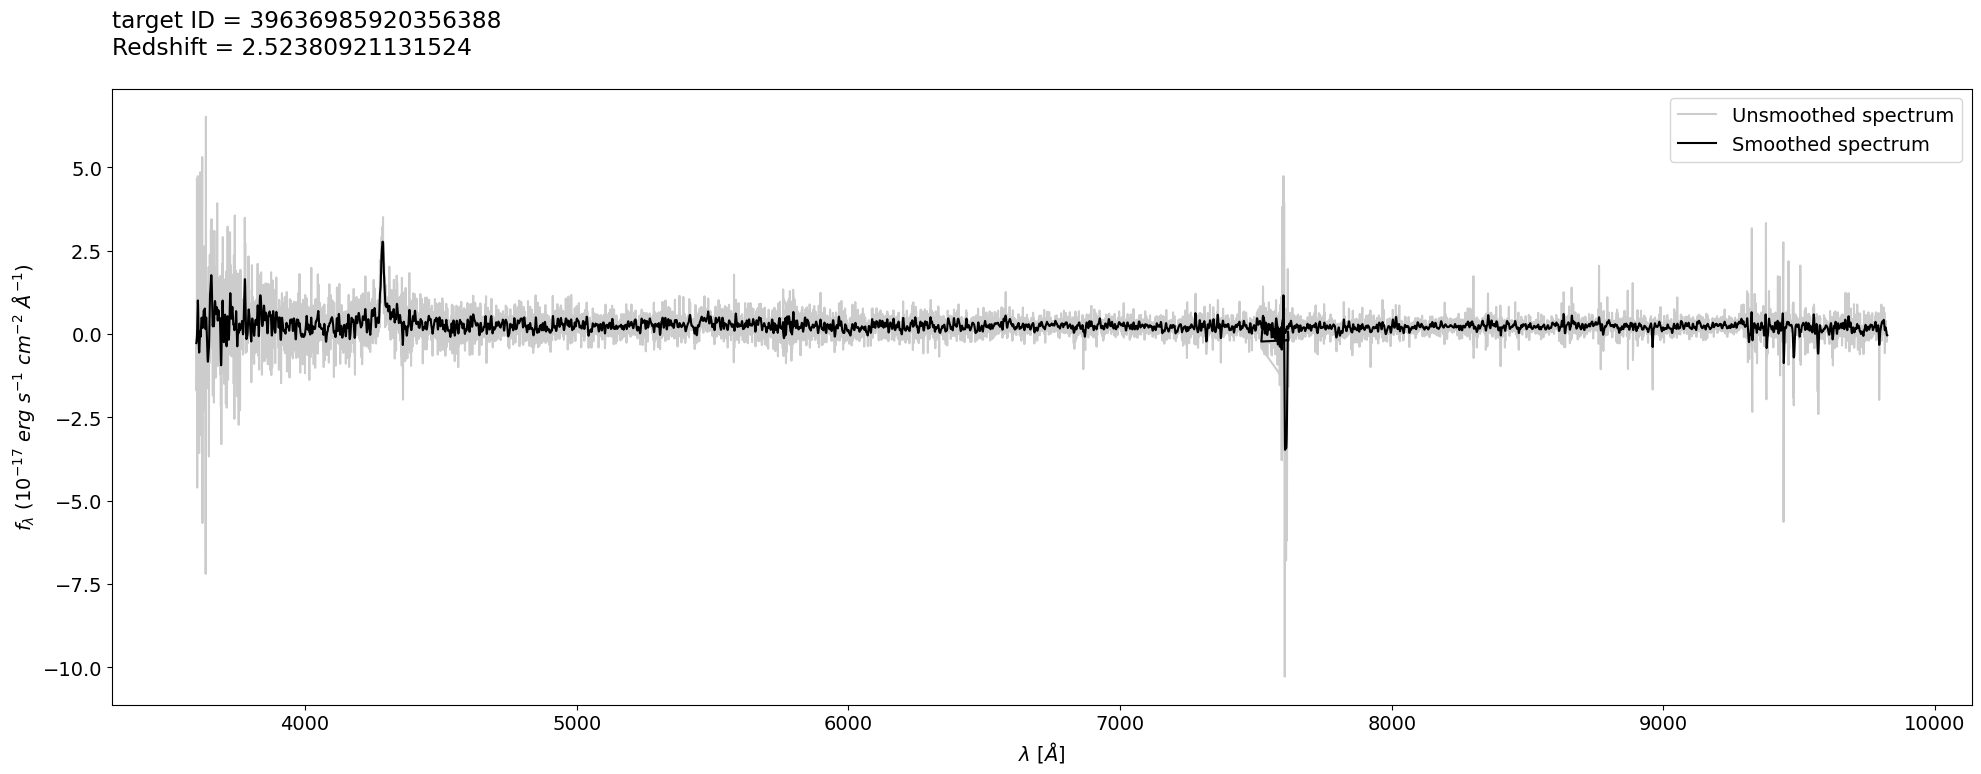

In [17]:
plot_spec(spectra = spectra, end = len(spectra), init = 0, path = "/pscratch/sd/j/juikuan/DESI_LAE_spectrum/Lya_catalog", Lya = False)

In [15]:
def fitting_Lya(spectra, end, path = None, init = 0, file_name = "Lya_emission", spectra_path = None):
    
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)

    TARGETID = []
    CHI2_MIN = []
    REDUCED_CHI2 = []
    PARAMS = []
    ASYMPTOTIC_ERROR = []
    STANDARD_ERROR = []
    WRONG_Z = []
    TRUE_Z = []
    LYA_FLUX = []
    LYA_EW = []
    n = 0
    
    for i in range(init, end):
        n += 1
        print(f"\rProcess: {str(n / end * 100)} %", end = "")
        record = spectra[i]
    
        flux = record.flux
        wavelength = record.wavelength
        model = record.model
        redshift = record.redshift
        ivar = record.ivar
        targetid = record.specid
        sparcl_id = record.sparcl_id
    
        min = 1215.67 * (redshift + 1) - 25
        max = 1215.67 * (redshift + 1) + 30
        mask_min = wavelength > min
        mask_max = wavelength < max
        w = wavelength[mask_min & mask_max]
        f = flux[mask_min & mask_max]
        m = model[mask_min & mask_max]
        iv = np.sqrt(ivar[mask_min & mask_max]) ** -1
        
        if redshift < 1.96 or redshift > 7.08:
            continue
        if np.max(f) == np.inf:
            f[np.where(f == np.inf)] = np.median(f)
        elif np.max(m) == np.inf:
            m[np.where(m == np.inf)] = np.median(fm)
        elif np.max(iv) == np.inf:
            iv[np.where(iv == np.inf)] = np.median(iv)

        def my_model(p, x):
            A, mu, sigma, zerolev = p
            return( A * np.exp(-(x-mu)*(x-mu)/(2.0*sigma*sigma)) + zerolev)
            
        def my_residuals(p, data):
            A, mu, sigma, zerolev = p
            x, y, err = data
            return (y - my_model(p,x)) / err

        fittings = list()
        for j in range(math.ceil(1215.67 * (redshift + 1)) - 10, math.floor(1215.67 * (redshift + 1)) + 15):

            fitobj = kmpfit.Fitter(residuals = my_residuals, data = (w, f, iv), parinfo = [{"limits": [0, 100000000]}, {"limits": [1215.67 * (redshift + 1) - 10, 1215.67 * (redshift + 1) + 15]}, {"limits": [0, 10000000]}, None])
            p0 = [np.amax(f), j, 2.5, 0.1]
            
            fitobj.fit(params0 = p0)

            chi2_min = fitobj.chi2_min
            reduced_chi2 = fitobj.rchi2_min
            params = fitobj.params
            asymptotic_error = fitobj.xerror
            standard_errors = fitobj.stderr
            
            wrong_z = redshift
            true_z = fitobj.params[1] / 1215.67 - 1
            
            area = fitobj.params[2] * fitobj.params[0] * np.sqrt(2 * math.pi)
            EW = area / (fitobj.params[3] * (fitobj.params[1] / 1215.67))

            fittings.append({"targetid": targetid, "chi2_min": chi2_min, "reduced_chi2": reduced_chi2, "params": params, "asymptotic_error": list(asymptotic_error), "standard_errors": list(standard_errors),"wrong_z": wrong_z, "true_z": true_z, "EW": EW, "area": area})
            fittings.sort(key = lambda x: (x["reduced_chi2"] - 1) ** 2)

        TARGETID.append(fittings[0]['targetid'])
        CHI2_MIN.append(fittings[0]['chi2_min'])
        REDUCED_CHI2.append(fittings[0]['reduced_chi2'])
        PARAMS.append(fittings[0]['params'])
        ASYMPTOTIC_ERROR.append(fittings[0]['asymptotic_error'])
        STANDARD_ERROR.append(fittings[0]['standard_errors'])
        WRONG_Z.append(fittings[0]['wrong_z'])
        TRUE_Z.append(fittings[0]['true_z'])
        LYA_FLUX.append(fittings[0]['area'])
        LYA_EW.append(fittings[0]['EW'])

        if spectra_path != None:
            plt.close()
            rc('font', size = 9)
            rc('legend', fontsize = 8)
            
            plt.title(f"Target ID = {fittings[0]['targetid']}\n"
                      f"chi^2 min = {fittings[0]['chi2_min']}\n"
                      f"Reduced Chi^2 = {fittings[0]['reduced_chi2']}\n"
                      f"Redshift = {fittings[0]['true_z']}\n"
                      f"Params = {fittings[0]['params']}\n"
                      f"Flux = {fittings[0]['area']}\n"
                      f"Rest Frame EW = {fittings[0]['EW']}\n"
                      f"Standard errors = {fittings[0]['standard_errors']}\n"
                      f"Asymptotic error = {fittings[0]['asymptotic_error']}", loc = 'left')
            
            plt.xlabel('$\lambda\ [\AA]$')
            plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
            plt.plot(w, f, color='k', alpha = 0.4, label = 'Unsmoothed spectrum')
            plt.plot(w, iv, color='g', alpha = 0.4, label = 'noise')
            # plt.plot(w, my_model(fittings[0]['params'], w), 'b', label = "Fit with kmpfit")
            plt.legend()
            plt.savefig(str(spectra_path) + f"{targetid}_Lya.png", bbox_inches ='tight')
    
    Lya_emission = []
    
    for i in (TARGETID, CHI2_MIN, REDUCED_CHI2, PARAMS, ASYMPTOTIC_ERROR, STANDARD_ERROR, WRONG_Z, TRUE_Z, LYA_FLUX, LYA_EW):
        Lya_emission.append(i)
        
    if path != None:
        t = Table(Lya_emission, names = ("TARGETID", "CHI2_MIN", "REDUCED_CHI2", "PARAMS", "ASYMPTOTIC_ERROR", "STANDARD_ERROR", "WRONG_Z", "TRUE_Z", "LYA_FLUX", "LYA_EW"))
        t.write(str(path) + str(file_name) + ".fits", format = "fits")
    else:
        pass

In [ ]:
spectra, results, records = selection_Lya(path = "../final_dataset/")

In [ ]:
fitting_Lya(spectra = spectra, end = len(spectra), path = "../final_dataset/", spectra_path = "../final_dataset/Lya_spectra_fitting/")

In [17]:
with open("../CNN/dataset/Spectra_sources/LAE_spectra_b_band.pkl", "rb") as fh:
    spectra = pickle.load(fh)

In [ ]:
plot_spec(spectra = spectra, end = len(spectra), init = 0, path = "../CNN/dataset/Lya_b_band", Lya = False)

In [ ]:
with open("../final_dataset/Lya_spectra.pkl", "rb") as fh:
    Lya = pickle.load(fh)
with open("../final_dataset/OII_spectra.pkl", "rb") as fh:
    OII = pickle.load(fh)

print(len(Lya))
print(len(OII))

In [22]:
with open("../DESI_LAE_dataset/ELG_spectra_b_band.pkl", "rb") as fh:
    Lya = pickle.load(fh)

In [23]:
Lya

[{'specid': 39627787786522692,
  'redshift': 1.35924706452874,
  'specprimary': True,
  'flux': array([-3.37089586e+00,  3.14815879e+00,  2.23689437e+00, ...,
          3.42097580e-01,  5.16076088e-01, -2.42609018e-03]),
  'wavelength': array([3600. , 3600.8, 3601.6, ..., 5548. , 5548.8, 5549.6]),
  'model': array([0.21627231, 0.28798887, 0.29730824, ..., 0.15459472, 0.14251809,
         0.10421186]),
  'ivar': array([ 0.23383233,  0.2489697 ,  0.23794252, ..., 10.66199875,
         10.72529888, 10.1224947 ]),
  'sparcl_id': '0e90ba9d-ab1b-4d2a-87ec-f6003acdaa56',
  '_dr': 'DESI-EDR'},
 {'specid': 39627817461221717,
  'redshift': 1.20330791443326,
  'specprimary': True,
  'flux': array([-0.48540118,  2.9422667 , -1.06697643, ...,  0.29173648,
          0.35405093,  0.5536229 ]),
  'wavelength': array([3600. , 3600.8, 3601.6, ..., 5548. , 5548.8, 5549.6]),
  'model': array([0.20715855, 0.27230075, 0.27990103, ..., 0.07756429, 0.07459896,
         0.06384986]),
  'ivar': array([ 0.136277